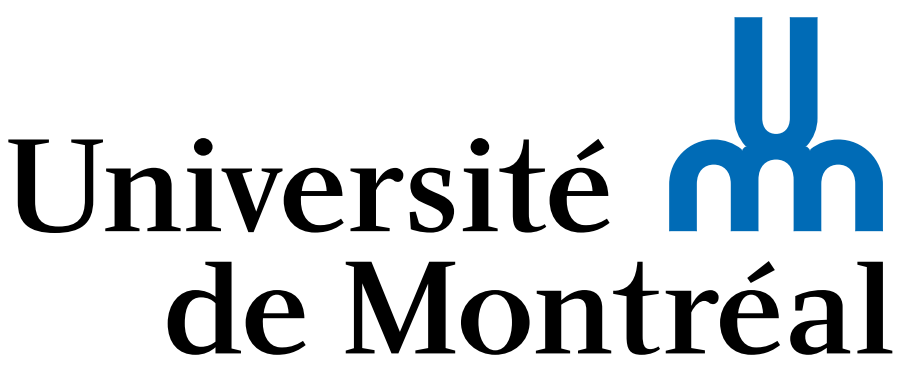

# IFT6285 (TALN) 

## Devoir 2: Modèles n-grammes avec kenlm

Réalisé par:

Mouna Dhaouadi 

Kacem Khaled

Soumis à:

Prof. Philippe Langlais

Frédéric Piedboeuf


**Automne 2021**

In [11]:
# run this in terminal
! wget -O - https://kheafield.com/code/kenlm.tar.gz |tar xz
! mkdir kenlm/build
! cd kenlm/build
! cmake ..
! make -j2

'wget' is not recognized as an internal or external command,
operable program or batch file.
The syntax of the command is incorrect.
The system cannot find the path specified.
'cmake' is not recognized as an internal or external command,
operable program or batch file.
'make' is not recognized as an internal or external command,
operable program or batch file.


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# installation de odule python kenlm
!pip install https://github.com/kpu/kenlm/archive/master.zip

  Using cached https://github.com/kpu/kenlm/archive/master.zip


In [3]:
import kenlm
model = kenlm.Model('bigram')
print(model.score('this is a sentence .', bos = True, eos = True))

OSError: Cannot read model 'bigram' (util\file.cc:74 in util::OpenReadOrThrow threw ErrnoException because `-1 == (ret = _open(name, 0x8000 | 0x0000))'. No such file or directory while opening C:\Users\kacem\Workspace\IFT6285\github-nlp\IFT6285-NLP\TP2\bigram)

In [ ]:
import kenlm
from statistics import mean

